<a href="https://colab.research.google.com/github/obeabi/AirlineSentiment/blob/main/Airline_NN_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Sentiment Dataset
## Written by Abiola Obembe
### Date: 2020-12-24

### Goal: Train a classifiier to predict customer sentiment from customer review text (using NN and pretrained word embeddings i.e. word2vec and glove)


A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Step 1: Data Cleaning and Preprocessing

In [201]:
# install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


print("installation complete!")


installation complete!


In [202]:
# Import dataset
dataset = pd.read_csv('Tweets.csv', encoding= 'latin1', engine='python', quoting = 1)

dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [203]:
# Drop columns not required
dataset.drop(columns = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
                        'airline', 'airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord',
                        'tweet_created','tweet_location','user_timezone'], axis = 1, inplace = True)
dataset.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn'tâ¦but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [204]:
#  Investigate the number of distinct sentiments
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

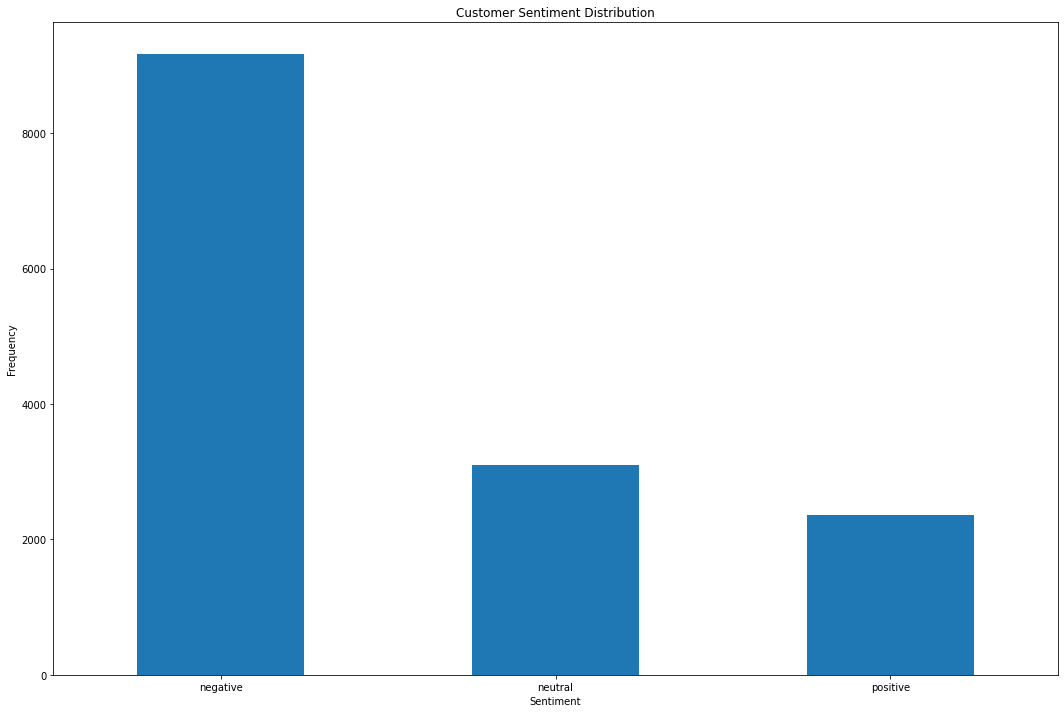

In [205]:
# Lets visualize the sentiments
count_classes = pd.value_counts(dataset['airline_sentiment'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Customer Sentiment Distribution")
plt.xticks(range(3))
plt.xlabel("Sentiment")
plt.ylabel('Frequency')
plt.show()

In [206]:
# Let us check for missing values in both columns
print(dataset.isnull().sum())

missing_values = dataset.isnull().sum().sum()
print('The total number of missing values in the dataframe is' , str(missing_values))

airline_sentiment    0
text                 0
dtype: int64
The total number of missing values in the dataframe is 0


In [207]:
## Data Cleaning

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
corpus = []




for i in range(0,dataset.shape[0]):
  reviews = re.sub(r"@[A-Za-z0-9]+", ' ', dataset['text'][i])
  reviews = re.sub(r'[^a-zA-Z]', ' ',reviews)
  # Removing additional whitespaces
  reviews = re.sub(r" +", ' ', reviews)
  reviews = reviews.lower()
  reviews = reviews.split()
  wl = WordNetLemmatizer()
  review = [wl.lemmatize(word) for word in reviews if not word in set(stopwords.words('english'))]
  review = ' '.join(review) 
  corpus.append(review)
 




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [208]:
# Install tensorflow
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds
print("Tensorflow version  :", tf.__version__)

Tensorflow version  : 2.4.0


## STEP 2: Tokenization and Padding

In [209]:
# import libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#
NB_words = 2**10
MAX_SEQ_LEN = 100   
tokenizer = Tokenizer(nb_words = NB_words)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
word_index = tokenizer.word_index 

print("Found unique tokens", len(word_index))

data = pad_sequences(sequences, value=0, padding="post", maxlen=MAX_SEQ_LEN)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found unique tokens 11850


In [210]:
# Let us encode the labels into integers 
from sklearn import preprocessing 
  
# label_encoder 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dataset['airline_sentiment']= label_encoder.fit_transform(dataset['airline_sentiment']) 
  
dataset['airline_sentiment'].unique() 

array([1, 2, 0])

In [211]:
# Split into train and validation/test set
y = dataset['airline_sentiment'].values

from keras.utils import  to_categorical
y = to_categorical(np.asarray(y))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( data, y, test_size=0.2, random_state=42)

[nsample,nshape] = X_train.shape
print(nsample)
print(nshape)

11712
100


### Obtain Word2Vec Embedding Matrix

In [212]:
# Now we need to get the pre-trained vectors for the word2vec embeddings
import gensim
import gensim.downloader as api

embeddings_ap = api.load("glove-wiki-gigaword-100") 


In [213]:
# After this we create an embedding matrix for the tokenized text for the reviews
vocab = tokenizer.texts_to_sequences(corpus)

# added one due to reserved index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

# create a weight matrix for words in the training document
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = embeddings_ap[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  except:
    pass

11851


In [214]:
# print embedding matrix
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1219    , -0.65645999,  0.50854999, ..., -0.23317   ,
        -0.013865  , -0.78455001],
       [ 0.14432999,  0.43950999,  0.58323997, ...,  0.50133997,
         0.49535999,  0.49919999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24322   , -0.80457997,  0.098619  , ..., -0.42359   ,
         0.35133001,  0.19468001],
       [-0.29222   , -0.53171003,  0.15395001, ..., -0.28490001,
         0.99054003,  0.1701    ]])

## Step 3: Build and Train Model

In [215]:
# Import keras libraries
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Input, Flatten, Embedding, concatenate
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

print("Installation sucessfull!")

Installation sucessfull!


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 100, 100)          1185100   
_________________________________________________________________
flatten_18 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               1000100   
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0  

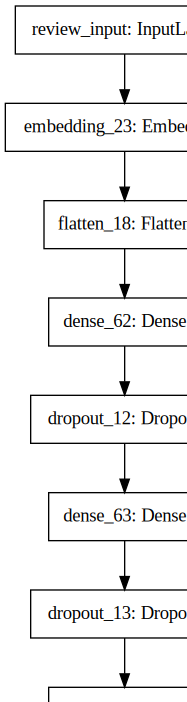

In [227]:
# Build Seq2Seq architecture

model1 = Sequential()

# Add Embedding Layer and number of output is 100 as we embedded with a 100D word2vec model
Embed_layer = Embedding(input_dim= vocab_size, output_dim= 100, weights = [embedding_matrix], input_length= (MAX_SEQ_LEN,), trainable = True )

# define inputs
review_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name = 'review_input')
review_embedding = Embed_layer(review_input)
Flatten_layer = Flatten()
Flatten_review = Flatten_layer(review_embedding)
output_size = 3

dense1 = Dense(100, activation='relu')(Flatten_review)
dense1 = Dropout(0.25)(dense1)
dense2 = Dense(64, activation='relu')(dense1)
dense2 = Dropout(0.4)(dense2)
dense3 = Dense(32, activation='relu')(dense2)
dense3 = Dropout(0.5)(dense3)
predict = Dense(output_size, activation='softmax')(dense3)


model1 = Model(inputs = [review_input], outputs= [predict])
model1.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics=["categorical_accuracy"])

print(model1.summary())

SVG(model_to_dot(model1).create(prog= 'dot', format ='svg'))



In [228]:
# Train the model
model1.fit(X_train,y_train, epochs = 10, batch_size = 2**5, verbose = True, validation_data = (X_test,y_test))

Epoch 1/10
366/366 [==============================] - 9s 24ms/step - loss: 0.8843 - categorical_accuracy: 0.6127 - val_loss: 0.6192 - val_categorical_accuracy: 0.7551
Epoch 2/10
366/366 [==============================] - 9s 24ms/step - loss: 0.6516 - categorical_accuracy: 0.7330 - val_loss: 0.5732 - val_categorical_accuracy: 0.7684
Epoch 3/10
366/366 [==============================] - 9s 24ms/step - loss: 0.5637 - categorical_accuracy: 0.7778 - val_loss: 0.5632 - val_categorical_accuracy: 0.7749
Epoch 4/10
366/366 [==============================] - 9s 24ms/step - loss: 0.4944 - categorical_accuracy: 0.8070 - val_loss: 0.5771 - val_categorical_accuracy: 0.7790
Epoch 5/10
366/366 [==============================] - 9s 24ms/step - loss: 0.4317 - categorical_accuracy: 0.8295 - val_loss: 0.5988 - val_categorical_accuracy: 0.7814
Epoch 6/10
366/366 [==============================] - 9s 24ms/step - loss: 0.3902 - categorical_accuracy: 0.8509 - val_loss: 0.6455 - val_categorical_accuracy: 0.769

In [218]:
# Save model
model1.save('Word2Vec_10epochs_NN')

INFO:tensorflow:Assets written to: Word2Vec_10epochs_NN/assets


INFO:tensorflow:Assets written to: Word2Vec_10epochs_NN/assets
